### Load the model weights

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
from facenet_pytorch import MTCNN
from PIL import Image
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class VGGFace(nn.Module):
    def __init__(self, in_channels, num_classes=2622, init_weights=True):
        super(VGGFace, self).__init__()
        self.init_weights = init_weights
        self.in_channels = in_channels
        self.num_classes = num_classes
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            # 1
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            #2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            #3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            #4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            #5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        )

        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes)
        )

        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)
    

    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [24]:
model = VGGFace(in_channels=3, init_weights=False)
feature_embedding = 128
num_features = model.linear_layers[-1].in_features
features = list(model.linear_layers.children())[:-1] # remove last layer
features.extend([nn.Linear(num_features, feature_embedding)]) # add our layer with 1024 outputs
model.linear_layers = nn.Sequential(*features)
model.load_state_dict(torch.load('misc/vggface_embedding_weights_10_0025.pth', map_location="cpu"))

<All keys matched successfully>

### Prepare testing images

The test images are made up of mostly images from the Labeled Faces in the Wild dataset (LFW). To split the dataset into images that we will pass to the model and ones we will test on, the LFW dataset contains over 13000 images of 5760 people, 1680 of which have more than 1 image. We use these 1680 people and use 1 of their images each as the test set (1680 images total), and the remaining images will be seen by the model.

https://www.kaggle.com/datasets/atulanandjha/lfwpeople

In [26]:
path = './lfw_dataset/lfw_funneled/'
list_of_images = []

folders = ("database", "database_test")
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

for dirname in os.listdir(path):
    image_folder_path = os.path.join(path, dirname)
    if os.path.isfile(image_folder_path):
        continue

    person_images = os.listdir(image_folder_path)
    person_num_images = len(person_images)
    curr_num_test_images = 0
    
    test_idx = 1 if person_num_images <= 1 else np.random.randint(0, person_num_images-1)

    for i, image in enumerate(person_images):
        img_dir = os.path.join(image_folder_path, image)
        img = Image.open(img_dir)
        if i == test_idx:
            img.save(os.path.join("database_test", image))
            curr_num_test_images += 1
        else:
            img.save(os.path.join("database", image))



Check that the correct number of images have been added to the dataset

In [29]:
print(len(os.listdir("database")))
print(len(os.listdir("database_test")))

11565
1680


Add other testing images to the dataset. We have also added some images of our group members for our own testing, but these won't be used for the accuracy calculations, just for visualizing the model.

In [28]:
# copy our own images to database

for dirname in os.listdir("database_own_images"):
    img_dir = os.path.join("database_own_images", dirname)
    img = Image.open(img_dir)
    img.save(os.path.join("database", dirname))

We calculate the embedding vector of each face in the LFW dataset, and then compare the distance of the embedding vector of a face we want to recognise. The K closest faces should be outputted.

In [30]:
tr = torchvision.transforms.Compose([
            torchvision.transforms.Normalize(
                (0.367035294117647, 0.41083294117647057, 0.5066129411764705), 
                (1, 1, 1)
            )
        ])

mtcnn = MTCNN(image_size=224, margin=0)

path = './database' 
name_to_vector = {}
for img_name in tqdm(os.listdir('./database')):
    img = Image.open(os.path.join(path, img_name))
    #print(img_name)
    img_cropped = mtcnn(img, save_path=f'misc/face_dataset/{img_name}')
    if img_cropped is None:
        continue
    img_cropped = tr(img_cropped)
    name_to_vector[img_name] = F.normalize(model(img_cropped.unsqueeze(0))).detach().numpy()


100%|██████████| 11565/11565 [20:07<00:00,  9.57it/s]


Helper function to get a person's name from the image name

In [31]:
def get_person_name(img_name):
    img_name = img_name.replace(".jpg", "")
    img_name = img_name.replace(".jpeg", "")
    img_name = img_name.replace("_", " ")
    img_name = ''.join([i for i in img_name if not i.isdigit()])
    return img_name.strip()

Get the accuracy for the 1680 test images, where correct is defined as an image of the same person is in the k nearest images.

In [32]:
num_correct = 0
num_incorrect = 0

k = 10

for img_name in tqdm(os.listdir("database_test")):
    img = Image.open(os.path.join("database_test", img_name))
    img_cropped = mtcnn(img)
    img_cropped = tr(img_cropped)
    feature_matrix = F.normalize(model(img_cropped.unsqueeze(0))).detach().numpy()

    pairs = []

    for name, vector in name_to_vector.items():
        distance = np.linalg.norm(vector - feature_matrix)
        pairs.append((name, distance))

    sorted_pairs = sorted(pairs, key=lambda x: x[1])[:k]
    top_k_names = [get_person_name(x[0]) for x in sorted_pairs]

    person_name = get_person_name(img_name)

    if person_name in top_k_names:
        num_correct += 1
        #print(f"{img_name} {top_k_names}")
        #print(f"correct: {img_name}")
    else:
        num_incorrect += 1
    

100%|██████████| 1680/1680 [03:38<00:00,  7.68it/s]


In [33]:
print(num_correct)
print(num_correct/(num_correct+num_incorrect))

652
0.3880952380952381


### Accuracy results:

Learning rate = 0.025
- k = 1: 0.186
- k = 10: 0.417
- k = 100: 0.661

Learning rate = 0.05
- k = 1: 0.180
- k = 10: 0.396
- k = 100: 0.665

### Analysis of results

With increasing the value of k (the number of nearest images considered) while being much smaller than the number of images in our dataset (> 13000), the accuracy is decent but not exceptionally high. This could be due to the fact that the model was initially trained on the Pinterest faces dataset, which only has 105 unique identities, which is not a lot of data to work with. 

Despite this, when we set k = 1 (only the closest match) and testing with a face that the model has never been trained on, the accuracy is around 20% which is surprisingly high given the accuracies for higher values of k. 

### Test with your own images
Visualizer to show the k nearest images to an image

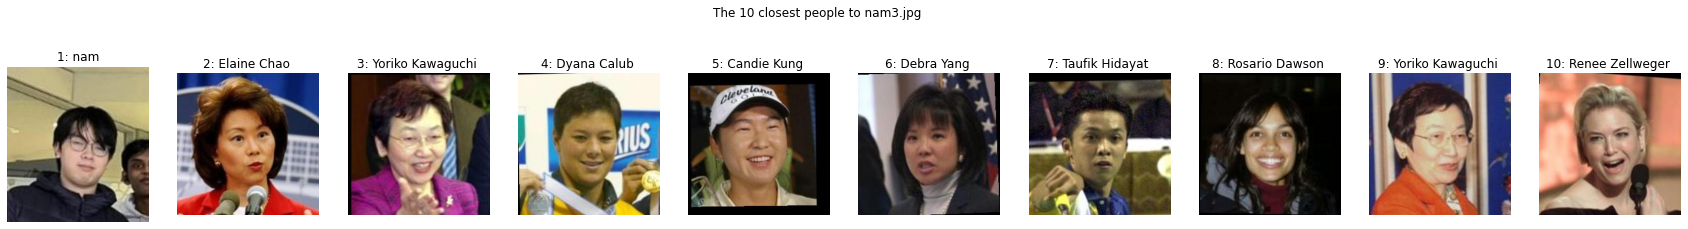

In [34]:
img_dir = './database'
test_dir = './database_own_tests'

person = 'nam3.jpg'
#person = np.random.choice(os.listdir("database_test"))

img = Image.open(os.path.join(test_dir, person)) 
img_cropped = mtcnn(img)
img_cropped = tr(img_cropped)
feature_matrix = F.normalize(model(img_cropped.unsqueeze(0))).detach().numpy()

pairs = []


smallest_dist = float('inf')
for name, vector in name_to_vector.items():
    distance = np.linalg.norm(vector - feature_matrix)
    pairs.append((name, distance))
    if distance < smallest_dist:
        smallest_dist = distance
        closest_person = name

sorted_pairs = sorted(pairs, key=lambda x: x[1])
k = 10
fig, ax = plt.subplots(1, k, figsize=(30, 4))
fig.suptitle(f"The {k} closest people to {person}")

for i in range(k):
    img = Image.open(os.path.join(img_dir, sorted_pairs[i][0]))
    ax[i].imshow(img)
    ax[i].set_axis_off()

    name = sorted_pairs[i][0]
    name = name.replace(".jpg", "")
    name = name.replace(".jpeg", "")
    name = name.replace("_", " ")
    name = ''.join([i for i in name if not i.isdigit()])
    
    ax[i].set_title(f"{i+1}: {name}")

plt.show()